In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

from matplotlib import patches
from yellowbrick.regressor import prediction_error, residuals_plot
import seaborn as sns
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from erebos.adapters import goes
from pvlib import spa, irradiance

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [126]:
sns.set_context('poster')
figsize=(10, 10)
crs = ccrs.PlateCarree()


In [127]:
site_data = xr.open_dataset('/storage/projects/goes_alg/site_data.nc')
mcmip = xr.open_dataset('OR_ABI-L2-MCMIPC-M3_G16_s20181672047231_e20181672050004_c20181672050119.nc')
mcmip.t

<xarray.DataArray 't' ()>
array('2018-06-16T20:48:41.788344960', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2018-06-16T20:48:41.788344960
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:      J2000 epoch mid-point between the start and end image sca...
    standard_name:  time
    axis:           T
    bounds:         time_bounds

In [128]:
ext = [-125, -100, 28, 50]
pts = mcmip.erebos.crs.transform_points(ccrs.Geodetic(), np.array(ext[:2]), np.array(ext[2:]))
x = mcmip.erebos.x
y = mcmip.erebos.y
okx = x[(x > pts[0, 0]) & (x < pts[1, 0])]
oky = y[(y > pts[0, 1]) & (y < pts[1, 1])]
ds = mcmip.erebos.sel(y=oky, x=okx)


## Domain Plot

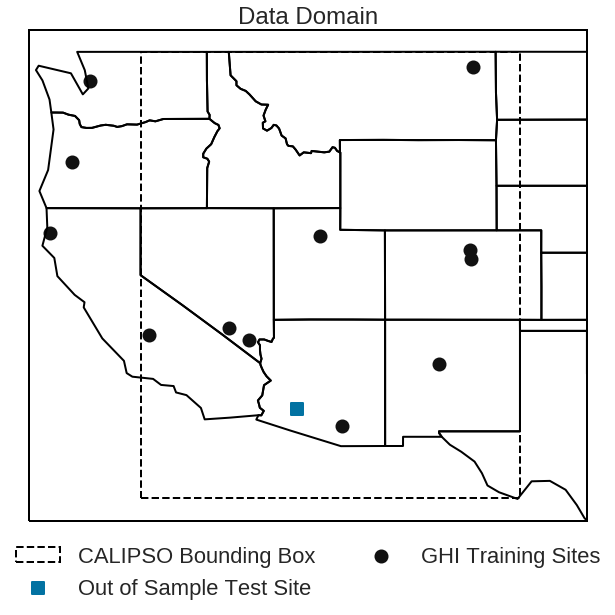

In [167]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)
ax.set_extent(ext, crs=crs)
ax.add_feature(cfeature.STATES)
calipso_ext = [-120, -103, 29, 49]

lons = []
lats = []
for site in site_data.site:
    lats.append(site_data.sel(site=site).latitude)
    lons.append(site_data.sel(site=site).longitude)
ax.scatter([-113], [33], marker='s', color='b', label='Out of Sample Test Site')
ax.scatter(lons, lats, color='k', label='GHI Training Sites')
rect = patches.Rectangle((-120, 29), 17, 20, fill=False, linestyle='--', label='CALIPSO Bounding Box')
ax.add_patch(rect)

leg = ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.2, -.2, .6, 0.2))
ax.set_title('Data Domain')
fig.savefig('domain.png', dpi=300)

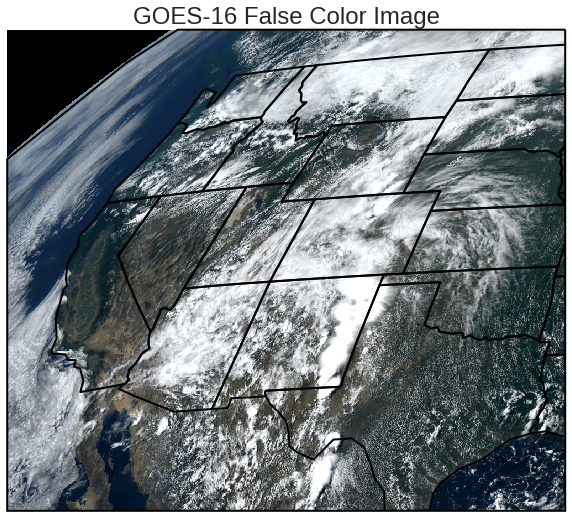

In [168]:
# from https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=mcmip.erebos.crs)

# Load the three channels into appropriate R, G, and B                                                                                                                                                                                                                                                                                                 
R = ds["CMI_C02"].data
NIR = ds["CMI_C03"].data
B = ds["CMI_C01"].data

# Apply range limits for each channel. RGB values must be between 0 and 1                                                                                                                                                                                                                                                                              
R = np.clip(R, 0, 1)
NIR = np.clip(NIR, 0, 1)
B = np.clip(B, 0, 1)

# Calculate the "True" Green                                                                                                                                                                                                                                                                                                                           
G = 0.45 * R + 0.1 * NIR + 0.45 * B
G = np.clip(G, 0, 1)

# Apply the gamma correction                                                                                                                                                                                                                                                                                                                           
gamma = 1 / 1.7
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

cleanIR = ds["CMI_C13"].data
ir_range = ds.max_brightness_temperature_C13.valid_range

cleanIR = (cleanIR - ir_range[0]) / (ir_range[1] - ir_range[0])
cleanIR = np.clip(cleanIR, 0, 1)
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright                                                                                                                                                                                                                                                                           
# when we overlay it on the true color image.                                                                                                                                                                                                                                                                                                          
cleanIR = cleanIR / 1.3

# Maximize the RGB values between the True Color Image and Clean IR image                                                                                                                                                                                                                                                                              
RGB_ColorIR = np.dstack(
    [np.maximum(R, cleanIR), np.maximum(G, cleanIR), np.maximum(B, cleanIR)]
)
CONTRAST = 105
F = (259 * (CONTRAST + 255)) / (255.0 * 259 - CONTRAST)
img = F * (RGB_ColorIR - 0.5) + 0.5
img = np.clip(img, 0, 1)  # Force value limits 0 through 1.   

ax.imshow(img, origin='upper', extent=[okx.min(), okx.max(), oky.min(), oky.max()])
ax.add_feature(cfeature.STATES)
ax.set_title('GOES-16 False Color Image')
fig.savefig('g16_img.png', dpi=300)

## Classification
confusion matrices for cloud/no clodu and cloud type

img of goes next to cloud type img

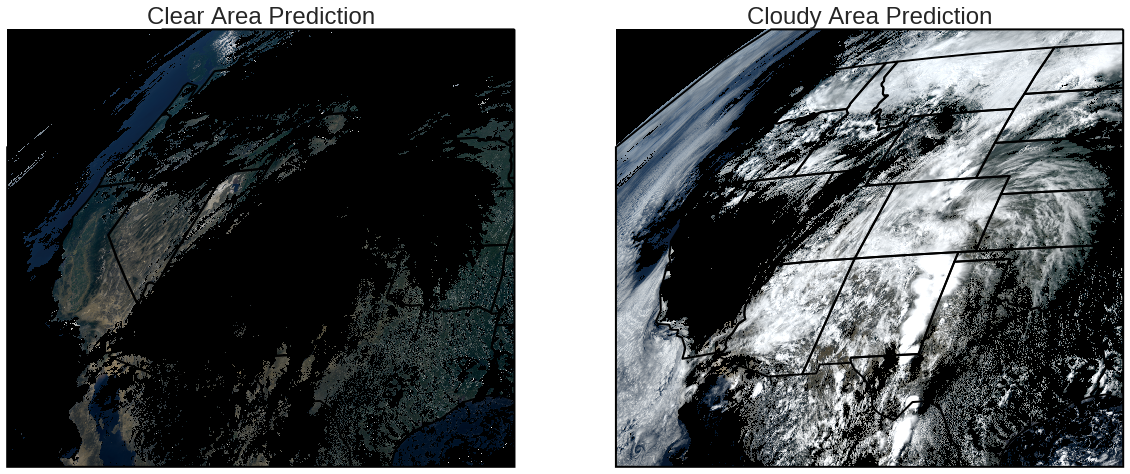

In [169]:
with open('cloud_mask.pkl', 'rb') as f:
    mask_model = pickle.load(f)


vars_ = [f'CMI_C{c:02d}' for c in range(1, 17)]
df = ds[vars_].to_dataframe()
df = df.drop(columns=[c for c in df.columns if c not in vars_])
nans = df.isna().any(axis=1) 
X = df.values[~nans]
mpred = mask_model.predict(X)
cmask = np.ma.ones(nans.shape)
cmask.mask = nans
cmask[~nans] = mpred
cmask = cmask.reshape((len(okx), len(oky))).T

fig = plt.figure(figsize=(2*figsize[0], figsize[1]))
ax = fig.add_subplot(121, projection=mcmip.erebos.crs)
ax.imshow(img * (1-np.tile(cmask[:, :, None], 3)), origin='upper', extent=[okx.min(), okx.max(), oky.min(), oky.max()])
ax.add_feature(cfeature.STATES)
ax.set_title('Clear Area Prediction')

ax1 = fig.add_subplot(122, projection=mcmip.erebos.crs)
ax1.imshow(img * np.tile(cmask[:, :, None], 3), origin='upper', extent=[okx.min(), okx.max(), oky.min(), oky.max()])
ax1.add_feature(cfeature.STATES)
ax1.set_title('Cloudy Area Prediction')
fig.savefig('mask_example.png', dpi=300)

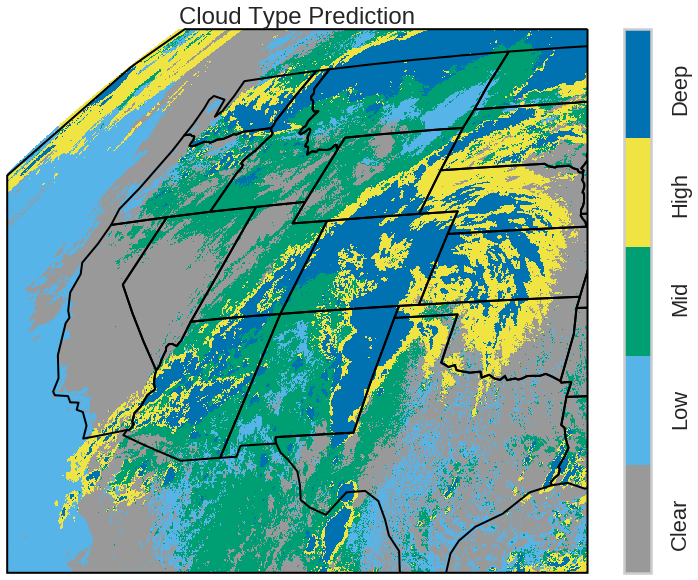

In [170]:
with open('cloud_type.pkl', 'rb') as f:
    type_model = pickle.load(f)


vars_ = [f'CMI_C{c:02d}' for c in range(1, 17)]
df = ds[vars_].to_dataframe()
df = df.drop(columns=[c for c in df.columns if c not in vars_])
nans = df.isna().any(axis=1) 
X = df.values[~nans]
tpred = type_model.predict(X)
ctype = np.ma.ones(nans.shape)
ctype.mask = nans
ctype[~nans] = tpred
ctype = ctype.reshape((len(okx), len(oky))).T

fig = plt.figure(figsize=(figsize[0] * 1.3, figsize[1]))
ax = fig.add_subplot(111, projection=mcmip.erebos.crs)
im = ax.imshow(ctype * cmask, origin='upper', extent=[okx.min(), okx.max(), oky.min(), oky.max()], 
          cmap=ListedColormap(
              #['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
              #['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
              #['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
              #['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']
              ["#999999", "#56B4E9", "#009E73", "#F0E442", "#0072B2"]
          ))
cb = fig.colorbar(im, ax=ax)
cb.set_ticks([0.5, 1.3, 2.1, 2.9, 3.7])
cb.ax.set_yticklabels(['Clear', 'Low', 'Mid', 'High', 'Deep'], rotation=90)
cb.ax.yaxis.set_ticks_position('none')

ax.add_feature(cfeature.STATES)
ax.set_title('Cloud Type Prediction')
ax.set_aspect('auto')
fig.savefig('cloud_type.png', dpi=300)

## height regresssion

show scatterplot on validation

show scatterplot using trained cloud type


In [9]:
with open('height.pkl', 'rb') as f:
    height_model = pickle.load(f)


vars_ = [f'CMI_C{c:02d}' for c in range(1, 17)]
df = ds[vars_].to_dataframe()
df = df.drop(columns=[c for c in df.columns if c not in vars_])
nans = df.isna().any(axis=1) 
df['cloud_type'] = pd.Series(tpred * mpred, index=df[~nans].index)

X = df.values[~nans]
hpred = height_model.predict(X)
height = np.ma.ones(nans.shape)
height.mask = nans
height[~nans] = hpred
height = height.reshape((len(okx), len(oky))).T

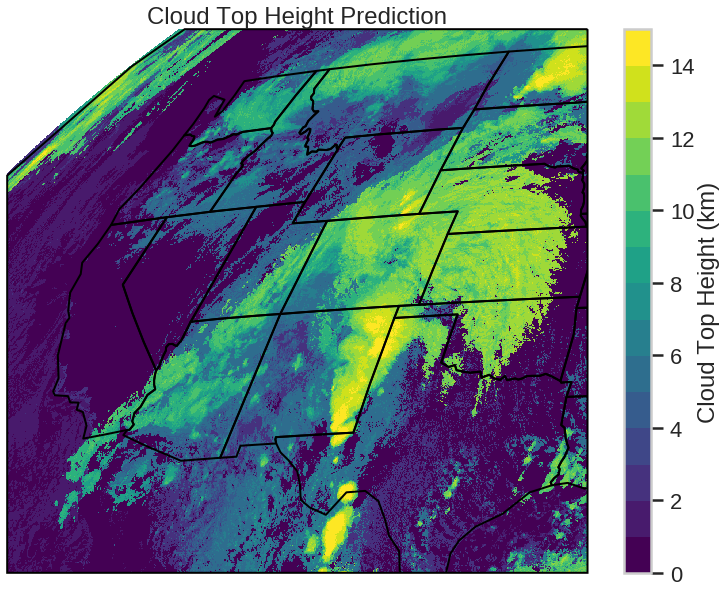

In [171]:
fig = plt.figure(figsize=(figsize[0] * 1.3, figsize[1]))
ax = fig.add_subplot(111, projection=mcmip.erebos.crs)
im = ax.imshow(height, origin='upper', extent=[okx.min(), okx.max(), oky.min(), oky.max()], 
               cmap=get_cmap('viridis', 15),
               vmin=0, vmax=15)
ax.add_feature(cfeature.STATES)
fig.colorbar(im, ax=ax, label='Cloud Top Height (km)')
ax.set_title('Cloud Top Height Prediction')
ax.set_aspect('auto')
fig.savefig('height_example.png', dpi=300)

## GHI plots

In [11]:
with open('year_ghi.pkl', 'rb') as f:
    ghi_model = pickle.load(f)

In [12]:
def get_data(sites, use_shift, data, var='ghi'):
    vars_ = [v for v in data.variables.keys() if v.startswith('CMI_C') ] + [
         'zenith', 'azimuth', 'extra_radiation', 'elevation', 'latitude', 'longitude']
    if use_shift:
        vars_ += ['cloud_type', 'height', 'cloudy']
        shifted = 1
    else:
        shifted = 0
    X = data[vars_]
    ok_zenith = (data['zenith'] < 90)
    y = (data[var] ).astype('float32').where(ok_zenith).sel(site=sites)
    X = X.where(ok_zenith).sel(site=sites).astype('float32')
    lenv = len(vars_) 
    Xo = X.isel(shifted=shifted).to_array().data.T.reshape((-1, lenv))
    yo = y.data.T.reshape(-1)
    nans = np.isnan(Xo).any(axis=1) | np.isnan(yo) | np.isinf(yo)
    Xo = Xo[~nans]
    yo = yo[~nans]
    cloudy= data['cloudy'].sel(site=sites).isel(shifted=shifted).data.reshape(-1)[~nans]
    return Xo, yo, cloudy


In [13]:
oos_site_data = xr.open_dataset('oos_data.nc')

ndata = xr.open_dataset('oos_one_year_mcmipc.nc').load()
for v in ('latitude', 'longitude', 'elevation'):
    ndata[v] = (('time', 'site'), 
               np.broadcast_to(oos_site_data[v], (ndata.dims['time'], ndata.dims['site'])))
ndata['extra_radiation'] = ('time', irradiance.get_extra_radiation(pd.DatetimeIndex(ndata.time.data)))

In [14]:
X_oos, y_oos, cloudy_oos = get_data(oos_site_data.site.data, True, ndata)


In [15]:
with open('ghi_sets.pkl', 'rb') as f:
    ghi_sets = pickle.load(f)


In [16]:
def calc_errors(X, y):
    y_prd = ghi_model.predict(X)
    rmse = np.sqrt(np.mean((y_prd - y)**2))
    mae = np.mean(np.abs(y_prd - y))
    mbe = np.mean(y_prd - y)
    return rmse, mae, mbe


In [17]:
train_err = calc_errors(ghi_sets['X_train'], ghi_sets['y_train'])

In [18]:
test_err = calc_errors(ghi_sets['X_test'], ghi_sets['y_test'])

In [19]:
oos_err = calc_errors(X_oos, y_oos)

In [20]:
calc_errors(X_oos[cloudy_oos == 1], y_oos[cloudy_oos == 1]), oos_err

((118.1604187767325, 78.30047284529293, 18.905189306348365),
 (76.41539760734275, 40.918771083950105, 12.946951646292874))

Text(0, 0.5, 'Predicted GHI (W/m^2)')

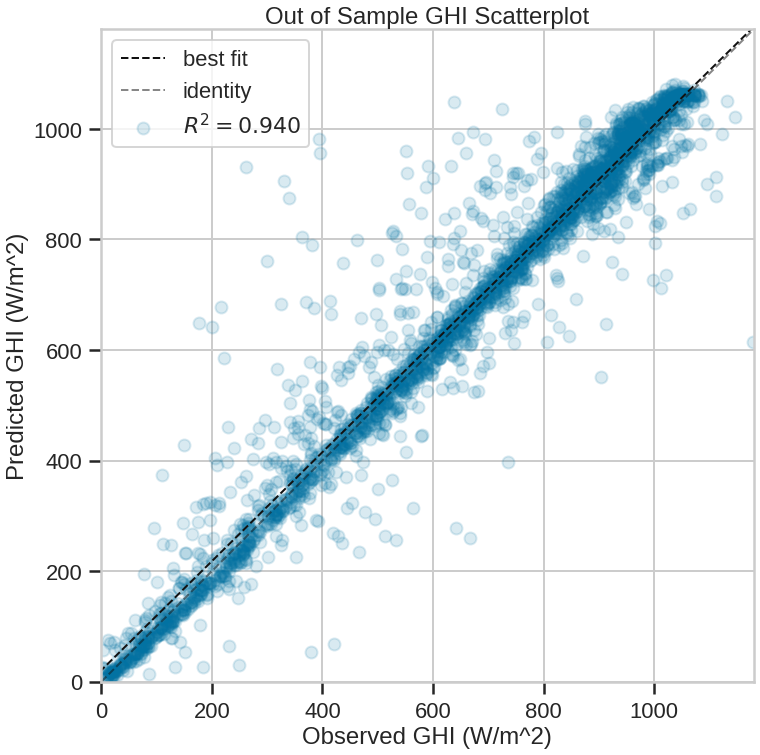

In [21]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
prediction_error(ghi_model, X_oos, y_oos, alpha=0.15, ax=ax, is_fitted=True)
ax.set_title('Out of Sample GHI Scatterplot')
ax.set_xlabel('Observed GHI (W/m^2)')
ax.set_ylabel('Predicted GHI (W/m^2)')

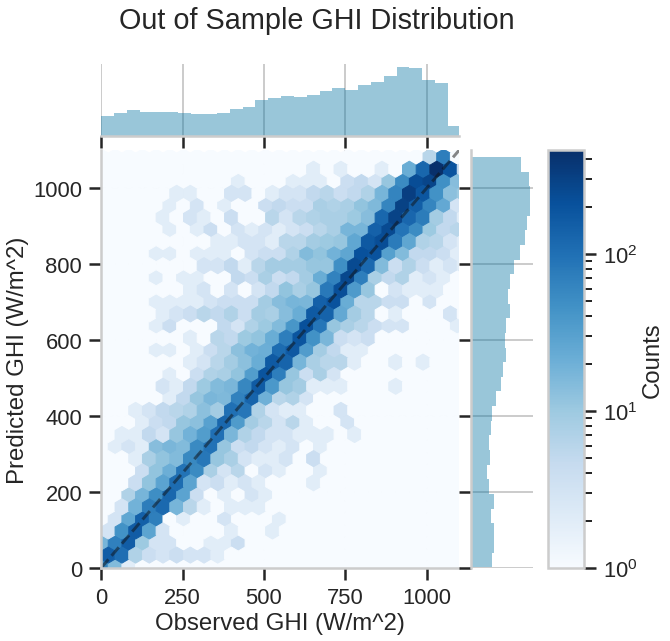

In [213]:
hexplot = (sns.JointGrid(x=y_oos, y=ghi_model.predict(X_oos), xlim=(0, 1100), ylim=(0, 1100), height=figsize[0])
     .plot_joint(plt.hexbin, gridsize=30, bins='log', cmap='Blues')
     .plot_marginals(sns.distplot, kde=False, color='b')
     .set_axis_labels('Observed GHI (W/m^2)', 'Predicted GHI (W/m^2)')
    )
hexplot.ax_joint.plot([0, 1200], [0, 1200], color='k', alpha=0.5, linestyle='--')
plt.suptitle('Out of Sample GHI Distribution')

plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = hexplot.fig.add_axes([.82, 0.2, .05, .58])  # x, y, width, height
plt.colorbar(cax=cbar_ax, label='Counts')
plt.savefig('ghi_hex.png', dpi=300)

In [22]:
pd.DataFrame({'Train Set': train_err, 'Test Set': test_err, 'Out of Sample Set': oos_err}, 
                       index=['RMSE', 'MAE', 'MBE']).T

,RMSE,MAE,MBE
Train Set,83.151658,47.122777,-4.183557
Test Set,91.377379,50.366247,-4.085773
Out of Sample Set,76.415398,40.918771,12.946952


In [28]:
vars_ = [f'CMI_C{c:02d}' for c in range(1, 17)]
other_vars = ['zenith', 'azimuth', 'extra_radiation', 'elevation', 'latitude', 'longitude', 
              'cloud_type', 'height', 'cloudy']
df = ds[vars_].to_dataframe()
df = df.drop(columns=[c for c in df.columns if c not in vars_])
nans = df.isna().any(axis=1) 
ind = df[~nans].index

Y, X = np.meshgrid(ds.y.data, ds.x.data)
locs = ccrs.Geodetic().transform_points(ds.crs.item(), X, Y)
lons = locs[:, :, 0].reshape(-1)
lats = locs[:, :, 1].reshape(-1)
solpos = spa.solar_position(ds.t.data.astype(int) / 10**9, lats, lons, 0, 101.325, 12, 67.0, 0.5667, 4)

df['cloud_type'] = pd.Series(tpred * mpred, index=ind)
df['cloudy'] = pd.Series(mpred, index=ind)
df['height'] = pd.Series(hpred, index=ind)
df['latitude'] = lats
df['longitude'] = lons
df['extra_radiation'] = irradiance.get_extra_radiation(ds.t.data)
df['zenith'] = solpos[1]
df['azimuth'] = solpos[-2]
# not quite right, but ok for visualization
df['elevation'] = 0
df = df[vars_ + other_vars]

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/pvlib/spa.py:733: RuntimeWarning: invalid value encountered in remainder
  return H % 360
/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/pvlib/spa.py:744: RuntimeWarning: invalid value encountered in tan
  u = np.arctan(0.99664719 * np.tan(np.radians(observer_latitude)))
/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/pvlib/spa.py:751: RuntimeWarning: invalid value encountered in cos
  * np.cos(np.radians(observer_latitude)))
/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/pvlib/spa.py:758: RuntimeWarning: invalid value encountered in sin
  * np.sin(np.radians(observer_latitude)))
/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/pvlib/spa.py:810: RuntimeWarning: invalid value encountered in sin
  np.sin(np.radians(observer_latitude))
/home/alorenzo/.pyenv/versions/mi

In [32]:
nans |= np.isinf(df).any(axis=1)
X = df.values[~nans]
ghi_pred = ghi_model.predict(X)
ghi = np.ma.ones(nans.shape)
ghi.mask = nans
ghi[~nans] = ghi_pred
ghi = ghi.reshape((len(okx), len(oky))).T

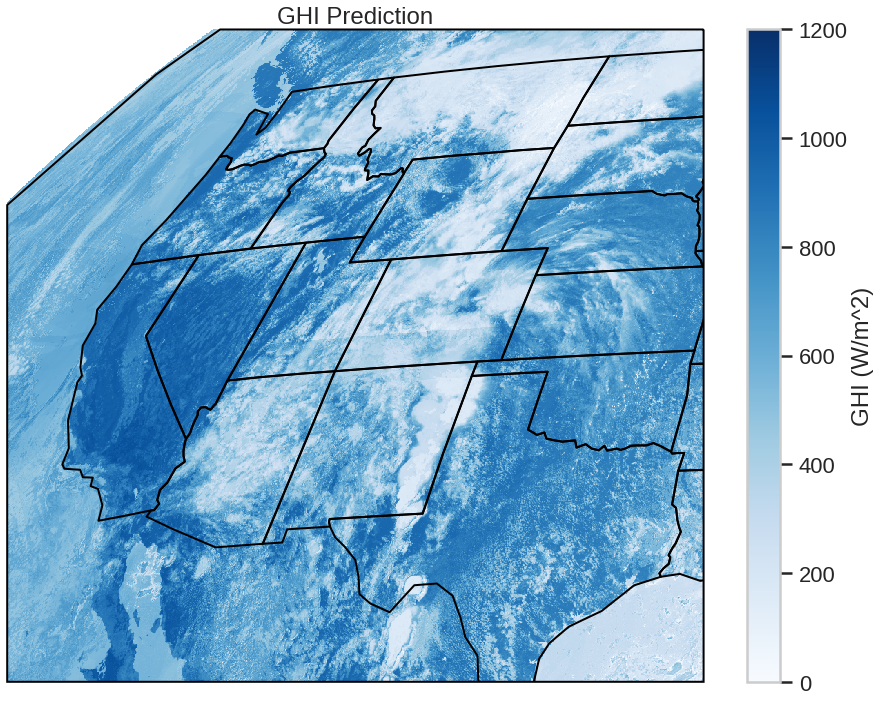

In [33]:
fig = plt.figure(figsize=(figsize[0] * 1.3, figsize[1]))
ax = fig.add_subplot(111, projection=mcmip.erebos.crs)
im = ax.imshow(ghi, origin='upper', extent=[okx.min(), okx.max(), oky.min(), oky.max()], cmap='Blues',
               vmin=0, vmax=1200)

cb = fig.colorbar(im, ax=ax, label='GHI (W/m^2)')
ax.add_feature(cfeature.STATES)
ax.set_title('GHI Prediction')
ax.set_aspect('auto')